
# 3D Seis2Rock - Volve Dataset <br> 
## Petrophysical Inversion on the 3D Volume



This notebook provides an illustration of the petrophysical inversion carried out on the 3D volume. The B coefficients have been created before hand following the procedure presented in Seis2Rock to save memory and computation time

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import pylops
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from scipy.ndimage import gaussian_filter

from seis2rock.seis2rock_functions import *
from seis2rock.seis2rock_utils import *

import os
from tqdm import tqdm
import glob
import pyvista as pv

np.random.seed(5)

## Loading and visualizing data needed

In [2]:
f = np.load('../../data/Volve2dfenceby1degree_NO_15_9-19_BT2.npz', 
            allow_pickle=True) 

# f.files

In [3]:
t_seis = f['t_seis']
t_vrms = f['t_vrms']
t_ainvt = f['t_ainvt']
dt = t_seis[1] - t_seis[0]

seismicd_prestack_fence=f['seismicd_prestack_fence'][:,25:,:] # Just taking positive angles
z_seismic_prestack_fence=f['z_seismic_prestack_fence']
dz = z_seismic_prestack_fence[1] - z_seismic_prestack_fence[0]

vtraces = f['vtraces']
vtraces_z = f['vtraces_z']

seismic_fence = f['seismict_fence']
vrms_fence = f['vrms_fence']
v_fence_depth=f['v_fence_depth']
aiinvt_fence = f['aiinvt_fence']
x_seis = np.arange(seismicd_prestack_fence.shape[0])

horizons_fence = f['horizons_fence'][()]

well_tvdss = f['well_tvdss']
well_twt = f['well_twt']
well_ai = f['well_ai']
well_si = f['well_si']
well_vp = f['well_vp']
well_vs = f['well_vs']
well_rho = f['well_rho']
well_phi = f['well_phi']
well_vsh = f['well_vsh']
well_sw = f['well_sw']

izwellfence=f['izwellfence']
itwellfence=f['itwellfence']
depth_fence=f['depth_fence']
zwell = f['zwell']
zwell_seismic = f['zwell_seismic']

xlsext = f['xlsext']
ilsext = f['ilsext']

well_prestack = f['well_prestack'][:,25:] # Just taking positive angles
well_ai_prestack_sampling = f['well_ai_prestack_sampling']
well_si_prestack_sampling = f['well_si_prestack_sampling']
well_vp_prestack_sampling = f['well_vp_prestack_sampling']
well_vs_prestack_sampling = f['well_vs_prestack_sampling']
well_rho_prestack_sampling = f['well_rho_prestack_sampling']

well_phi_prestack_sampling = f['well_phi_prestack_sampling']
well_vsh_prestack_sampling = f['well_vsh_prestack_sampling']
well_sw_prestack_sampling = f['well_sw_prestack_sampling']

well_vtrace_prestack_sampling= f['well_vtrace_prestack_sampling']


offset = np.load('../../data/doffset_fence_well_NO_15_9-19_BT2.npy')  
wellname = 'NO 15/9-19 A'

Let's load the second well

In [4]:
f2 = np.load('../../data/Volve2dfenceby1degree_NO_15_9-19_A.npz',
            allow_pickle=True) 

In [5]:
well_tvdss_2 = f2['well_tvdss']
well_twt_2 = f2['well_twt']
well_ai_2 = f2['well_ai']
well_si_2 = f2['well_si']
well_vp_2 = f2['well_vp']
well_vs_2 = f2['well_vs']
well_rho_2 = f2['well_rho']
well_phi_2 = f2['well_phi']
well_vsh_2 = f2['well_vsh']
well_sw_2 = f2['well_sw']

well_prestack_2 = f2['well_prestack']
zwell_seismic_2 = f2['zwell_seismic']
z_seismic_prestack_fence_2 = f2['z_seismic_prestack_fence']
well_vp_prestack_sampling_2 = f2['well_vp_prestack_sampling']
well_vs_prestack_sampling_2 = f2['well_vs_prestack_sampling']
well_rho_prestack_sampling_2 = f2['well_rho_prestack_sampling']
well_phi_prestack_sampling_2 = f2['well_phi_prestack_sampling']
well_vsh_prestack_sampling_2 = f2['well_vsh_prestack_sampling']
well_sw_prestack_sampling_2 = f2['well_sw_prestack_sampling']



### Prestack Data

Plot the data in offset, angle, and the area of inversion

In [6]:
## Get the window depth for the prestack where the well log has information. 
window_min, window_max, well_start_data, well_end_data = get_depth_window_fence_Volve(well_vp_prestack_sampling=well_vp_prestack_sampling, 
                                                                                      zwell_seismic=zwell_seismic, 
                                                                                      z_seismic_prestack_fence=z_seismic_prestack_fence)

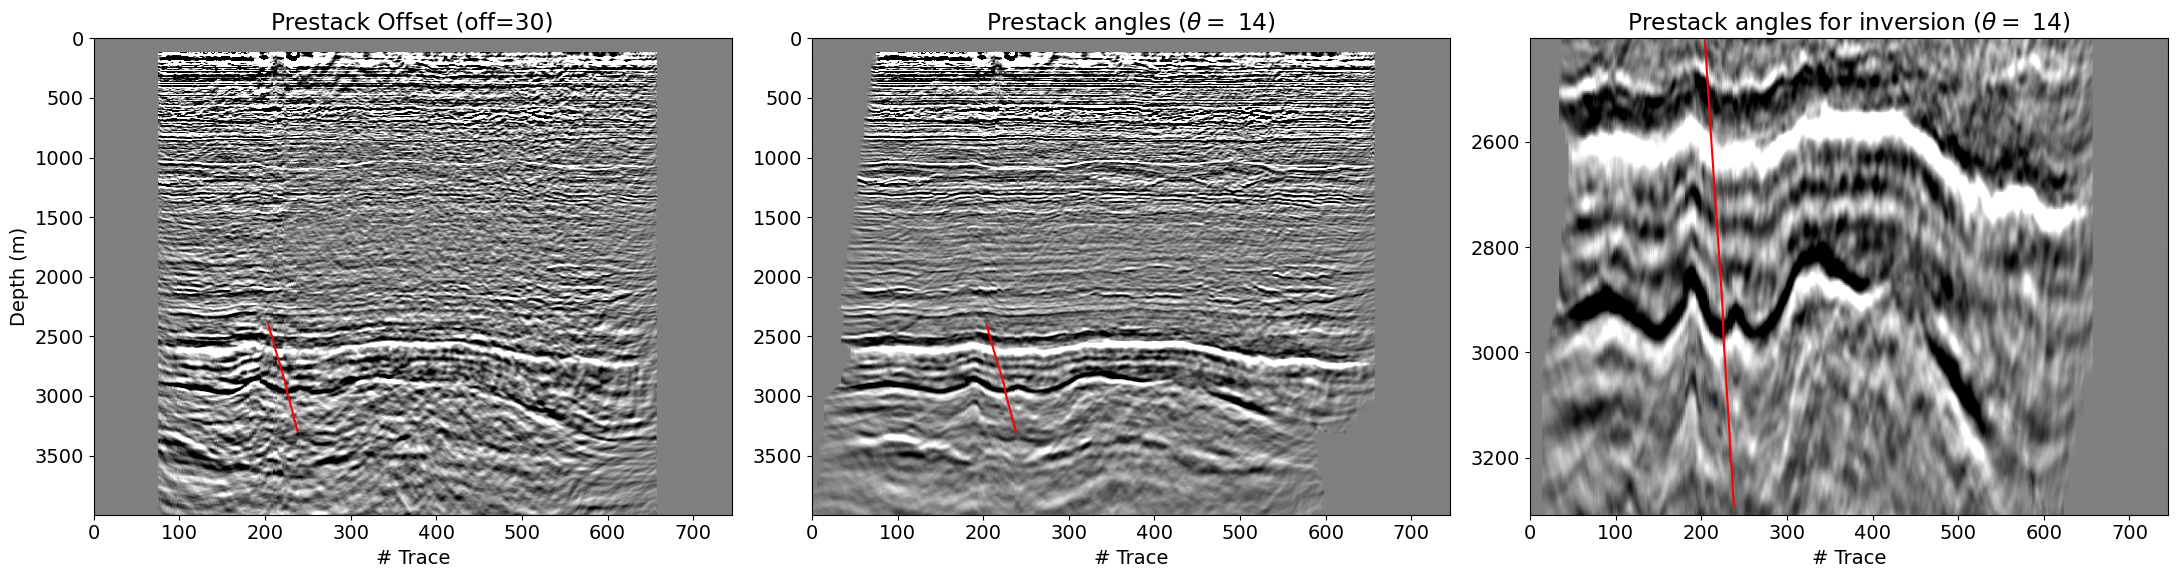

In [7]:
## Plot the data 
fig = plot_Volve_seismic_data(wellname=wellname, offset_num=30, angle=14, 
                            zwell=zwell, z_seismic_prestack_fence=z_seismic_prestack_fence, 
                            window_min=window_min, window_max=window_max, 
                            offset=offset, seismicd_prestack_fence=seismicd_prestack_fence,
                            fontsize=14, title_on=False)

Therefore, the prestack for wavelet estimatonis:

In [8]:
d = seismicd_prestack_fence[:,:,window_min:window_max]

In [245]:
d.shape, seismicd_prestack_fence.shape

((745, 25, 226), (745, 25, 1000))

### Wavelet estimation

Lastly, we need to acquire the necessary wavelet. This step is crucial for further analysis and processing. Here we use the wavelet scaling obtained in one of the previous notebooks. 

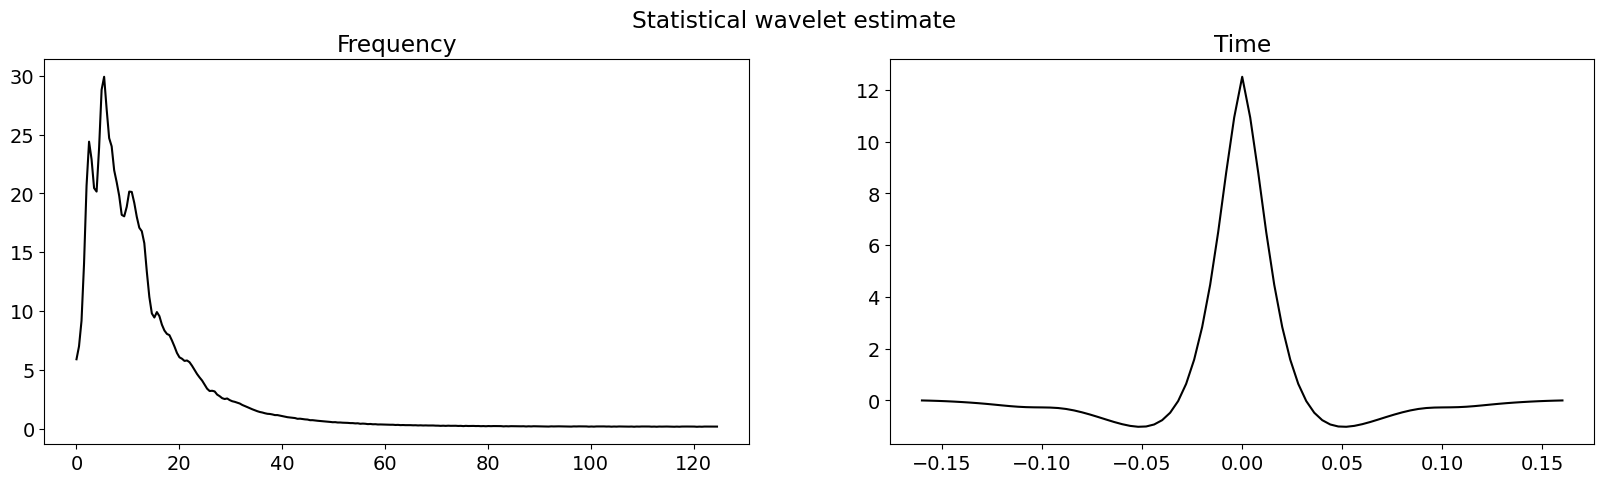

In [9]:
# Statistical Wavelet estimation
nfft = 512
nt_wav = 41
# wav_scaling =18
wav_scaling =12.5

wav_est, t_wav ,fwest, wav_est_fft = get_wavelet_estimate(nt_wav=nt_wav, nfft=nfft, wav_scaling=wav_scaling, 
                                    prestack_data=d, 
                                    dt=dt)


# Display wavelet
display_wavelet(wav_est= wav_est, fwest=fwest, wav_est_fft=wav_est_fft, 
                t_wav= t_wav, nfft=nfft, fontsize = 14)

In [209]:
#Processing elastic logs
vp, vs, rho, vp_back, vs_back, rho_back = process_well_logs(log_1=well_vp_prestack_sampling, 
                                                            log_2=well_vs_prestack_sampling, 
                                                            log_3=well_rho_prestack_sampling, 
                                                            depth_min=well_start_data, 
                                                            depth_max=well_end_data,
                                                            nsmooth=40)

#If AI and SI logs are needed: 
ai = vp*rho
si = vs*rho

#Processing petrophysical logs
phi, vsh, sw, phi_back, vsh_back, sw_back = process_well_logs(log_1=well_phi_prestack_sampling, 
                                                              log_2=well_vsh_prestack_sampling, 
                                                              log_3=well_sw_prestack_sampling, 
                                                              depth_min=well_start_data, 
                                                              depth_max=well_end_data,
                                                              nsmooth=40)


## Seis2Rock framework

Here we upload the B_optavo coefficients provided to save time and memory

In [10]:
b_test = np.load('../../data/B_3D_test.npy')

Visualizing the B coefficeints

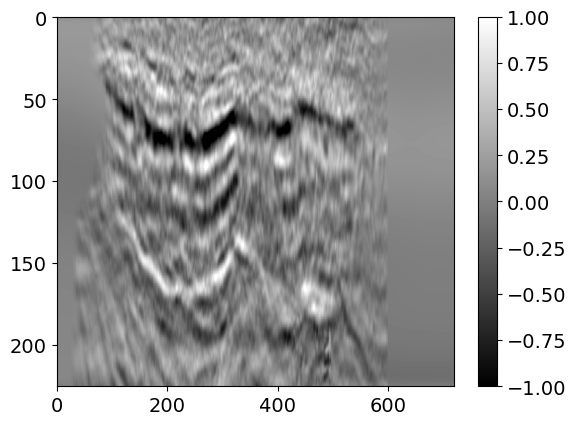

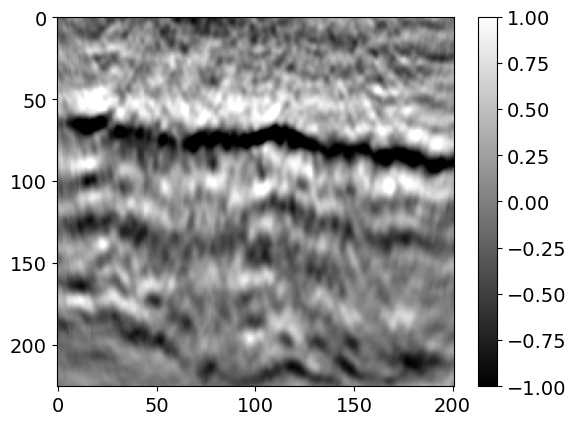

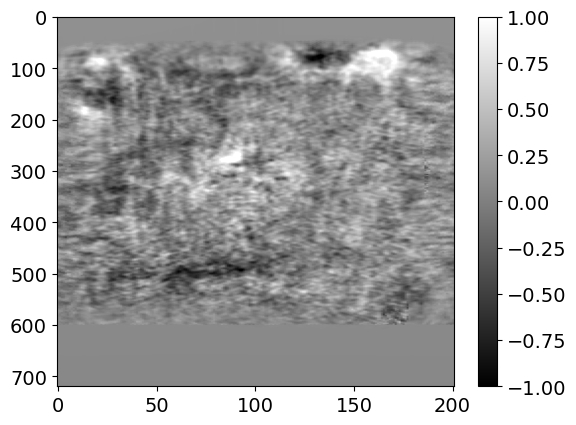

In [11]:
plt.figure()
plt.imshow(b_test[0,0,:,:], cmap='gray', vmin=-1, vmax=1)
plt.axis('tight')
plt.colorbar()

plt.figure()
plt.imshow(b_test[:,0,:,500].T, cmap='gray', vmin=-1, vmax=1)
plt.axis('tight')
plt.colorbar()

plt.figure()
plt.imshow(b_test[:,0,0,:].T, cmap='gray', vmin=-1, vmax=1)
plt.axis('tight')
plt.colorbar()

In [246]:
b_test.shape

(201, 3, 226, 720)

In [12]:
# Order axis for inversion and smaller cube to match bg velocities
# b_optAVO = b_optAVO.transpose(1,2,3,0)[:,:,200:400,:]
b_optAVO = b_test.transpose(1,2,3,0)[:,:,200:400,:]
b_optAVO.shape

(3, 226, 200, 201)

Loading the background models for 3D test

In [13]:
stacked_bg_phi = np.load('../../data/stacked_bg_phi_test.npy')
stacked_bg_vsh = np.load('../../data/stacked_bg_vsh_test.npy')
stacked_bg_sw = np.load('../../data/stacked_bg_sw_test.npy')

In [14]:
## Series of poststack seismic inversion (one per parameter)
## Here we use B as our 'new data term' which is the petrophysical coefficients

## Creating Post Stack Operator
kind ='forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=(b_optAVO.shape[2],b_optAVO.shape[3]),explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO.shape[1],  b_optAVO.shape[2], b_optAVO.shape[3]], dtype='float64')




## Hyperparameters for optimization
niter = 50
lamba1 = 0.1
damp1 = 4


## Inverting for porosity
print('Inverting for porosity...')
phi_inv_dense_reg = regularized_inversion(D, b_optAVO[0].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(stacked_bg_phi.transpose(2,1,0).ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(b_optAVO[0].shape) 
print('Porosity Done!')

## Inverting for vsh
print('Inverting for vsh...')
vsh_inv_dense_reg = regularized_inversion(D, b_optAVO[1].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(stacked_bg_vsh.transpose(2,1,0).ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(b_optAVO[0].shape) 
print('Vsh Done!')

## Inverting for sw
print('Inverting for sw...')
sw_inv_dense_reg = regularized_inversion(D, b_optAVO[2].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=stacked_bg_sw.transpose(2,1,0).ravel(),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(b_optAVO[0].shape) 

print('Sw Done!')


Inverting for porosity...
Porosity Done!
Inverting for vsh...
Vsh Done!
Inverting for sw...
Sw Done!


Let's see the inversion results in 2D profiles

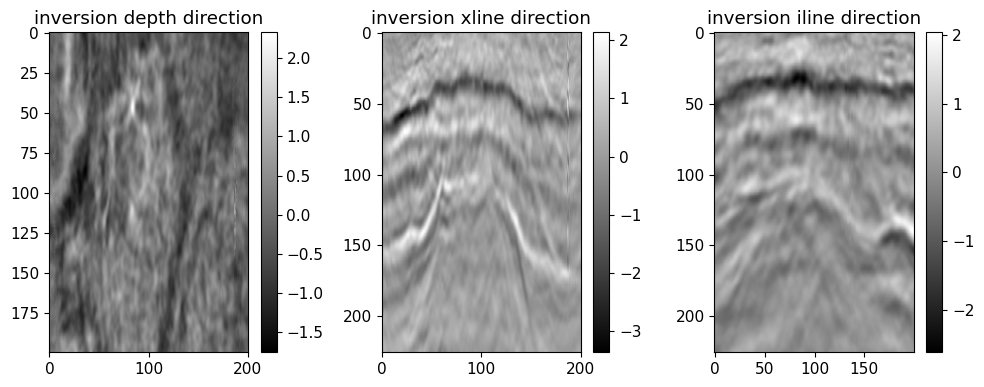

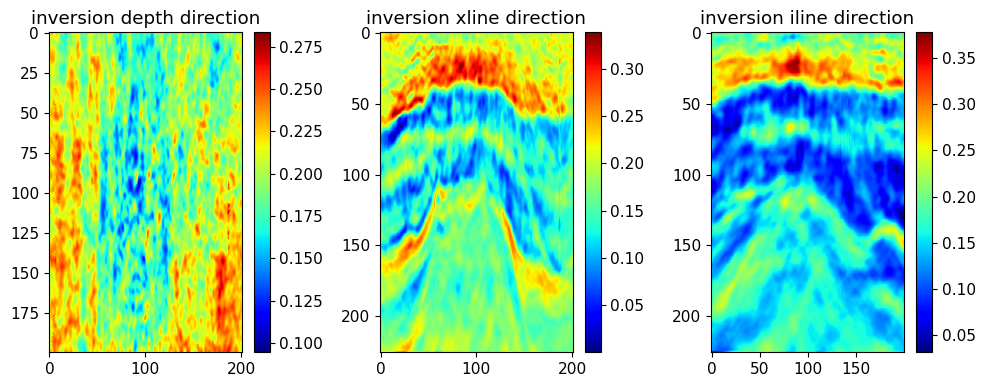

In [15]:
fig = plot_Volve_data_as_2d(data=b_optAVO, title='inversion', line_index=100, property_index=0,cmap='gray', fontsize=11)
fig = plot_Volve_data_as_2d(data=phi_inv_dense_reg, title='inversion', line_index=100, property_index=0,cmap='jet', fontsize=11)


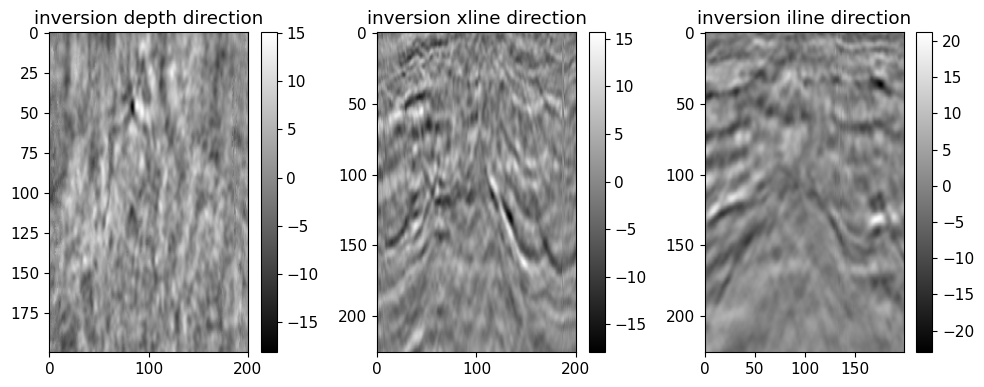

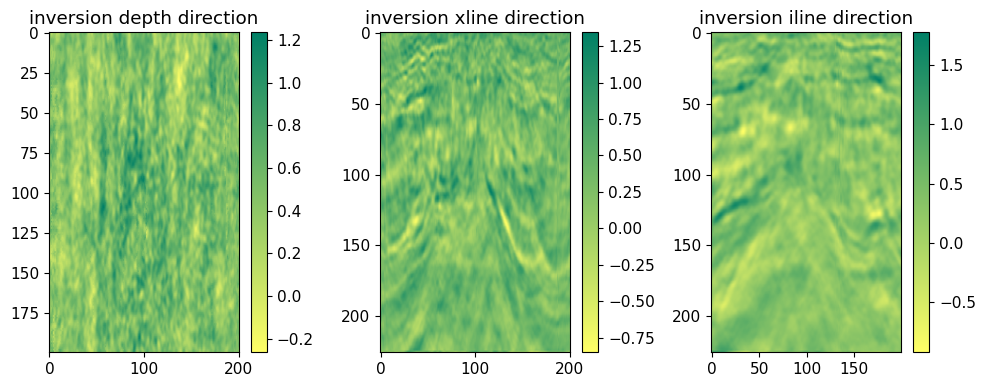

In [16]:
fig = plot_Volve_data_as_2d(data=b_optAVO, title='inversion', line_index=100, property_index=1,cmap='gray', fontsize=11)
fig = plot_Volve_data_as_2d(data=vsh_inv_dense_reg, title='inversion', line_index=100, property_index=1,cmap='summer_r', fontsize=11)


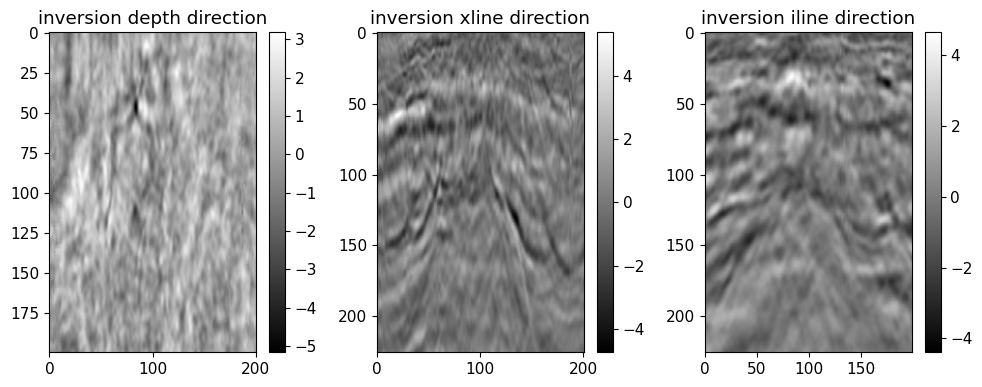

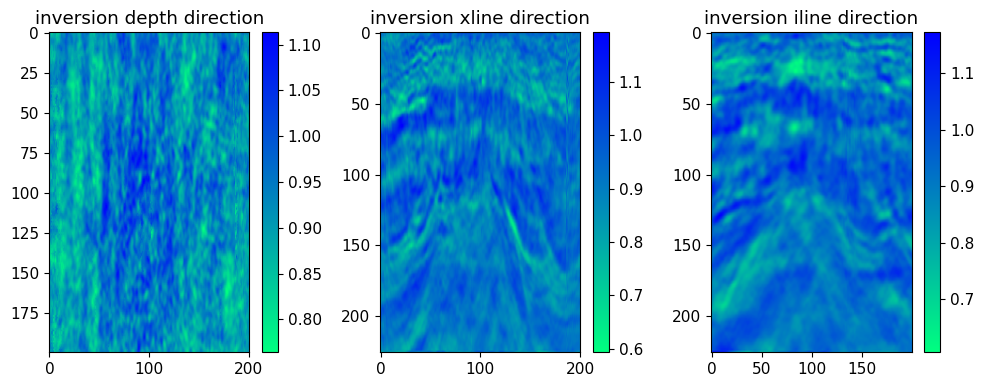

In [17]:
fig = plot_Volve_data_as_2d(data=b_optAVO, title='inversion', line_index=100, property_index=2,cmap='gray', fontsize=11)
fig = plot_Volve_data_as_2d(data=sw_inv_dense_reg, title='inversion', line_index=100, property_index=2,cmap='winter_r', fontsize=11)

### 3D plots

In [18]:
#Directory to save the plots
os.makedirs('plots_3D', exist_ok=True)

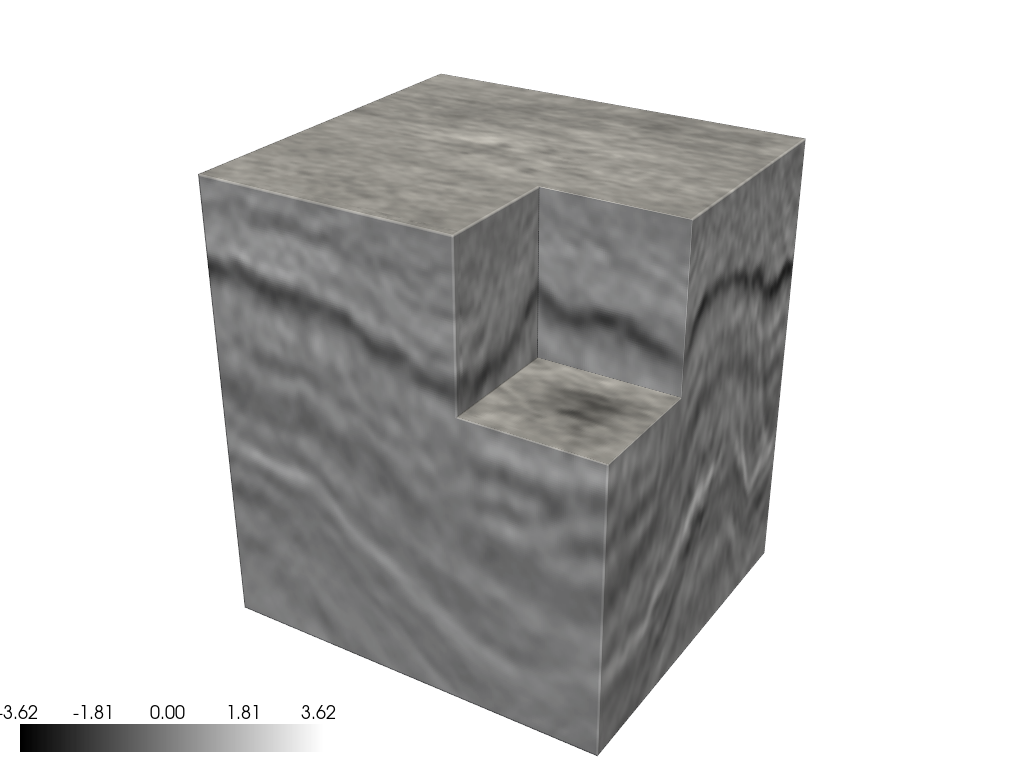

In [19]:
# vmin, vmax = -3,3
# vmin, vmax = b_optAVO[0].min(), b_optAVO[0].max()
max_b = max(b_optAVO[0].min(), b_optAVO[0].max())
vmin, vmax = -max_b,max_b
m_small = b_optAVO[0].transpose(2,1,0)[10:-10].copy()
grid = pv.UniformGrid(dims=np.array(m_small.shape) + 1)
grid.cell_data["values"] = np.flip(m_small, axis=-1).flatten(order="F")
clipped = grid.clip_box()


p = pv.Plotter()
p.add_mesh(clipped, cmap='gray', clim=[vmin, vmax],
           smooth_shading=True, metallic=1, show_scalar_bar=True,
           scalar_bar_args={'height': 0.1, 'width': 0.3,
                            'vertical': False,  # Horizontal bar
                            'position_x': 0.02,  # X position
                            'position_y': 0.02,  # Y position
                            'title': '',
                            'color': "black"})
p.camera_position = [8, 5, 5]
light = pv.Light(light_type='camera light', intensity=0.6)
p.add_light(light)
# p.screenshot('plots_3D/3D_Bcoeff.png', transparent_background=True)
p.show()

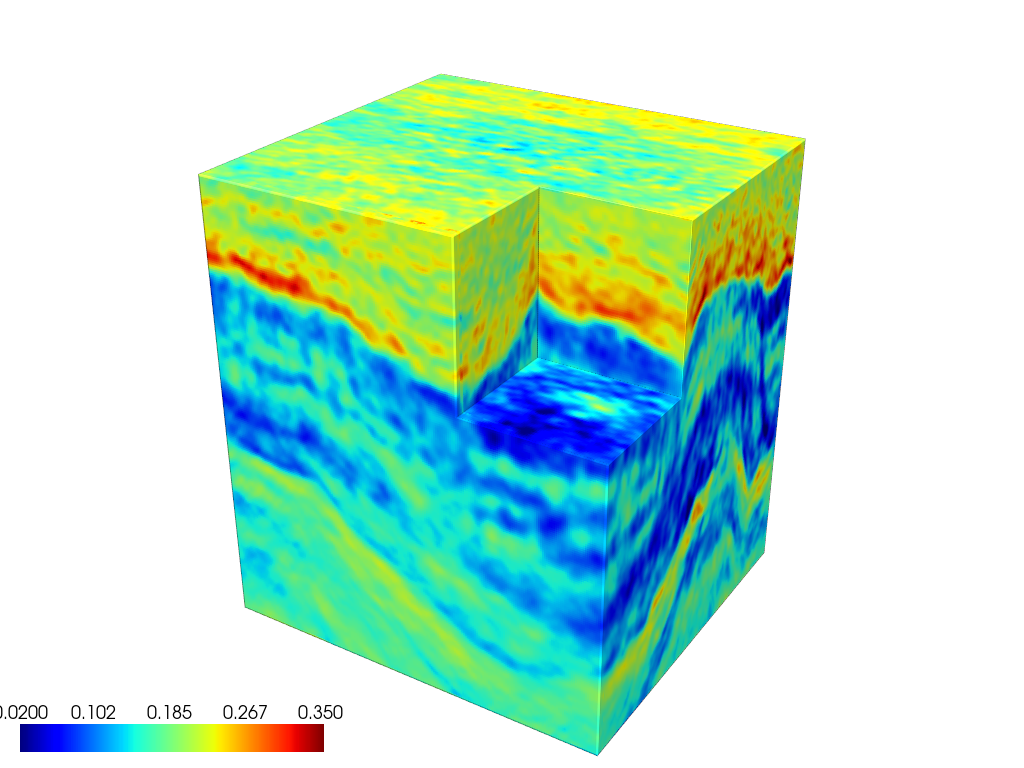

In [20]:
max_b = max(phi_inv_dense_reg.min(), phi_inv_dense_reg.max())
vmin, vmax = 0.02,0.35
m_small = phi_inv_dense_reg.transpose(2,1,0)[10:-10].copy()
grid = pv.UniformGrid(dims=np.array(m_small.shape) + 1)
grid.cell_data["values"] = np.flip(m_small, axis=-1).flatten(order="F")
clipped = grid.clip_box()


p = pv.Plotter()
p.add_mesh(clipped, cmap='jet', clim=[vmin, vmax],
           smooth_shading=True, metallic=1, show_scalar_bar=True,
           scalar_bar_args={'height': 0.1, 'width': 0.3,
                            'vertical': False,  # Horizontal bar
                            'position_x': 0.02,  # X position
                            'position_y': 0.02,  # Y position
                            'title': '',
                            'color': "black"})
p.camera_position = [8, 5, 5]
light = pv.Light(light_type='camera light', intensity=0.6)
p.add_light(light)
# p.screenshot('plots_3D/3D_phi.png', transparent_background=True)
p.show()

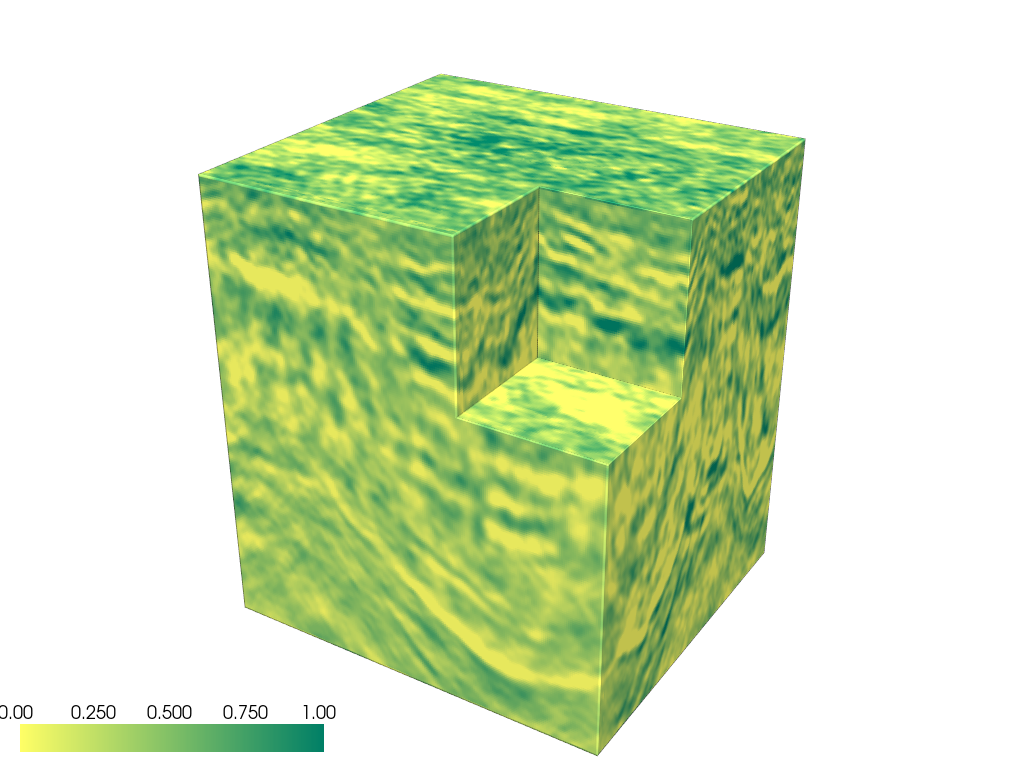

In [21]:
# max_b = max(vsh_inv_dense_reg.min(), vsh_inv_dense_reg.max())
vmin, vmax = 0.0,1.0
# vmin, vmax = np.percentile(vsh_inv_dense_reg, [5, 95])
m_small = vsh_inv_dense_reg.transpose(2,1,0)[10:-10].copy()
grid = pv.UniformGrid(dims=np.array(m_small.shape) + 1)
grid.cell_data["values"] = np.flip(m_small, axis=-1).flatten(order="F")
clipped = grid.clip_box()


p = pv.Plotter()
p.add_mesh(clipped, cmap='summer_r', clim=[vmin, vmax],
           smooth_shading=True, metallic=1, show_scalar_bar=True,
           scalar_bar_args={'height': 0.1, 'width': 0.3,
                            'vertical': False,  # Horizontal bar
                            'position_x': 0.02,  # X position
                            'position_y': 0.02,  # Y position
                            'title': '',
                            'color': "black"})
p.camera_position = [8, 5, 5]
light = pv.Light(light_type='camera light', intensity=0.6)
p.add_light(light)
# p.screenshot('plots_3D/3D_vsh.png', transparent_background=True)
p.show()

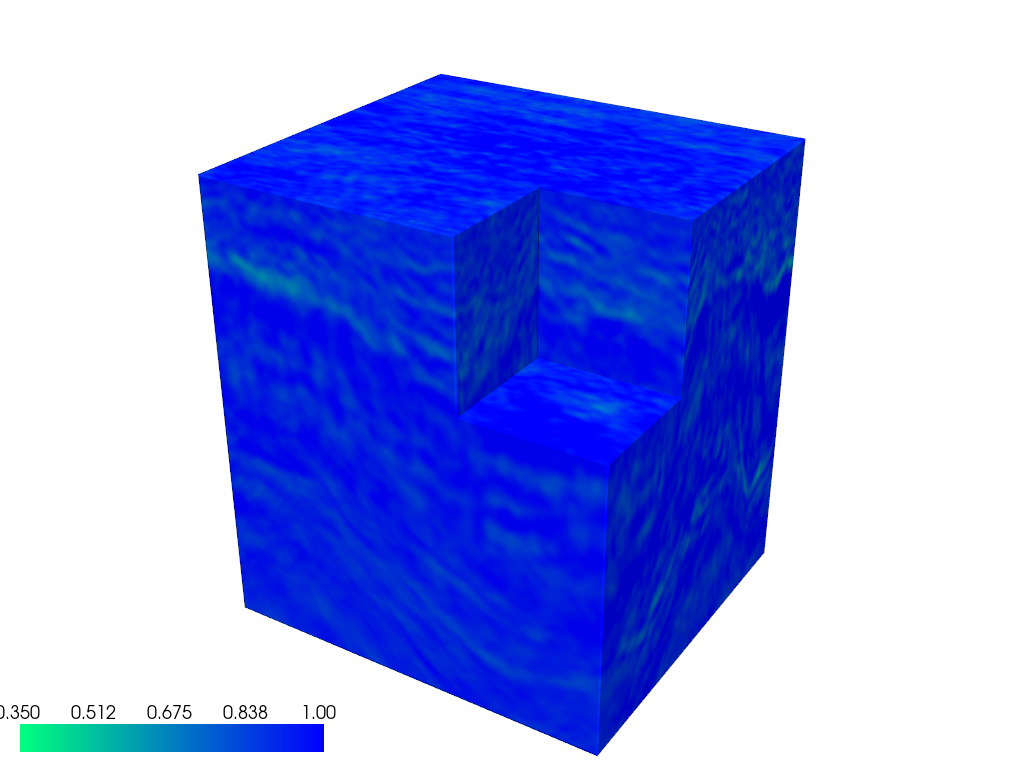

In [22]:
# max_b = max(sw_inv_dense_reg.min(), sw_inv_dense_reg.max())
vmin, vmax = 0.35,1.00
# vmin, vmax = np.percentile(sw_inv_dense_reg, [5, 95])
m_small = sw_inv_dense_reg.transpose(2,1,0)[10:-10].copy()
grid = pv.UniformGrid(dims=np.array(m_small.shape) + 1)
grid.cell_data["values"] = np.flip(m_small, axis=-1).flatten(order="F")
clipped = grid.clip_box()


p = pv.Plotter()
p.add_mesh(clipped, cmap='winter_r', clim=[vmin, vmax],
           smooth_shading=True, metallic=1, show_scalar_bar=True,
           scalar_bar_args={'height': 0.1, 'width': 0.3,
                            'vertical': False,  # Horizontal bar
                            'position_x': 0.02,  # X position
                            'position_y': 0.02,  # Y position
                            'title': '',
                            'color': "black"})
p.camera_position = [8, 5, 5]
light = pv.Light(light_type='camera light', intensity=0.6)
p.add_light(light)
# p.screenshot('plots_3D/3D_sw.png', transparent_background=True)
p.show()